In [71]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import cv2

In [72]:
class Img2Vec():
    RESNET_OUTPUT_SIZES = {
        'resnet18': 512,
        'resnet34': 512,
        'resnet50': 2048,
        'resnet101': 2048,
        'resnet152': 2048
    }

    EFFICIENTNET_OUTPUT_SIZES = {
        'efficientnet_b0': 1280,
        'efficientnet_b1': 1280,
        'efficientnet_b2': 1408,
        'efficientnet_b3': 1536,
        'efficientnet_b4': 1792,
        'efficientnet_b5': 2048,
        'efficientnet_b6': 2304,
        'efficientnet_b7': 2560
    }

    def __init__(self, cuda=False, model='google/vit-base-patch16-224', gpu=0):
        """
        Img2Vec with Vision Transformer
        :param cuda: If set to True, will run forward pass on GPU
        :param model: String name of requested model (e.g., 'vit-base-patch16-224')
        """
        self.device = torch.device(f"cuda:{gpu}" if cuda else "cpu")
        self.model_name = model
        self.model = ViTModel.from_pretrained(model)
        self.feature_extractor = ViTFeatureExtractor.from_pretrained(model)
        self.model = self.model.to(self.device)
        self.model.eval()

    def get_vec(self, img, tensor=False):
        """
        Get vector embedding from PIL image
        :param img: PIL Image or list of PIL Images
        :param tensor: If True, get_vec will return a FloatTensor instead of Numpy array
        :returns: Numpy ndarray
        """
        if type(img) == list:
            inputs = self.feature_extractor(images=img, return_tensors="pt")
            inputs = {key: value.to(self.device) for key, value in inputs.items()}
            with torch.no_grad():
                outputs = self.model(**inputs)
            embeddings = outputs.last_hidden_state.mean(dim=1)
            return embeddings if tensor else embeddings.cpu().numpy()
        else:
            inputs = self.feature_extractor(images=img, return_tensors="pt")
            inputs = {key: value.to(self.device) for key, value in inputs.items()}
            with torch.no_grad():
                outputs = self.model(**inputs)
            embedding = outputs.last_hidden_state.mean(dim=1)
            return embedding if tensor else embedding.cpu().numpy()

    def _get_model_and_layer(self, model_name, layer):
        """ Internal method for getting layer from model
        :param model_name: model name such as 'resnet-18'
        :param layer: layer as a string for resnet-18 or int for alexnet
        :returns: pytorch model, selected layer
        """

        if model_name.startswith('resnet') and not model_name.startswith('resnet-'):
            model = getattr(models, model_name)(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = self.RESNET_OUTPUT_SIZES[model_name]
            else:
                layer = model._modules.get(layer)
            return model, layer
        elif model_name == 'resnet-18':
            model = models.resnet18(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = 512
            else:
                layer = model._modules.get(layer)

            return model, layer

        elif model_name == 'alexnet':
            model = models.alexnet(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = 4096
            else:
                layer = model.classifier[-layer]

            return model, layer

        elif model_name == 'vgg':
            # VGG-11
            model = models.vgg11_bn(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = model.classifier[-1].in_features # should be 4096
            else:
                layer = model.classifier[-layer]

            return model, layer

        elif model_name == 'densenet':
            # Densenet-121
            model = models.densenet121(pretrained=True)
            if layer == 'default':
                layer = model.features[-1]
                self.layer_output_size = model.classifier.in_features # should be 1024
            else:
                raise KeyError('Un support %s for layer parameters' % model_name)

            return model, layer

        elif "efficientnet" in model_name:
            # efficientnet-b0 ~ efficientnet-b7
            if model_name == "efficientnet_b0":
                model = models.efficientnet_b0(pretrained=True)
            elif model_name == "efficientnet_b1":
                model = models.efficientnet_b1(pretrained=True)
            elif model_name == "efficientnet_b2":
                model = models.efficientnet_b2(pretrained=True)
            elif model_name == "efficientnet_b3":
                model = models.efficientnet_b3(pretrained=True)
            elif model_name == "efficientnet_b4":
                model = models.efficientnet_b4(pretrained=True)
            elif model_name == "efficientnet_b5":
                model = models.efficientnet_b5(pretrained=True)
            elif model_name == "efficientnet_b6":
                model = models.efficientnet_b6(pretrained=True)
            elif model_name == "efficientnet_b7":
                model = models.efficientnet_b7(pretrained=True)
            else:
                raise KeyError('Un support %s.' % model_name)

            if layer == 'default':
                layer = model.features
                self.layer_output_size = self.EFFICIENTNET_OUTPUT_SIZES[model_name]
            else:
                raise KeyError('Un support %s for layer parameters' % model_name)

            return model, layer

        else:
            raise KeyError('Model %s was not found' % model_name)

In [73]:
import unittest
from PIL import Image

In [74]:
from transformers import ViTModel, ViTFeatureExtractor
iv = Img2Vec(cuda=True, model='google/vit-base-patch16-224', gpu=0)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [75]:
t = torch.load(r'/kaggle/input/train-data-part-1/1_train_data.tar.pth')
print(t.keys()) # it will print data and targets
data, targets = t['data'], t['targets'] # both numpy.ndarray

dict_keys(['data', 'targets'])


/tmp/ipykernel_30/1291131315.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  t = torch.load(r'/kaggle/input/train-data-part-1/1_train_data.tar.pth')


In [77]:
type(data)

numpy.ndarray

In [78]:
unique_classes = np.unique(targets)
print(unique_classes)

[0 1 2 3 4 5 6 7 8 9]


### Calculation of average Vector

In [79]:
vecs = []
for cls in unique_classes:
    cls_imgs = data[targets == cls]
    cls_vecs = []
    for imgs in cls_imgs:
        im = Image.fromarray(imgs)
        features = iv.get_vec(im)
        cls_vecs.append(features)
    vecs.append(cls_vecs)

In [80]:
features.shape

(1, 768)

In [81]:
print(type(vecs))
print(len(vecs), len(vecs[0]), vecs[0][0].shape)

<class 'list'>
10 253 (1, 768)


In [82]:
# import numpy as np

# Reshape vecs to remove the singleton dimension
reshaped_vecs = [[features.squeeze() for features in cls_vecs] for cls_vecs in vecs]

print(type(reshaped_vecs))
print(len(reshaped_vecs), len(reshaped_vecs[0]), reshaped_vecs[0][0].shape)

<class 'list'>
10 253 (768,)


In [83]:
avg_vec = []
for i in reshaped_vecs:
    arr = np.array(i)
    mean = np.mean(arr, axis = 0)
    avg_vec.append(mean)
avg_vec = np.array(avg_vec)

In [84]:
avg_vec.shape

(10, 768)

### Visualization for better Understanding

In [20]:
from sklearn.manifold import TSNE

/tmp/ipykernel_30/3750343311.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", avg_vec.shape[0])  # A colormap with unique colors


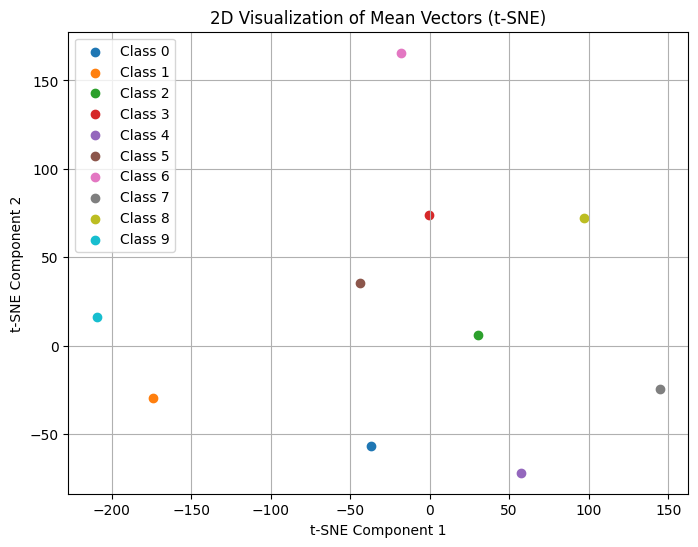

In [21]:
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
avg_vec_2d = tsne.fit_transform(avg_vec)

# Visualize the 2D scatter plot
plt.figure(figsize=(8, 6))

# Assign unique colors for each class
colors = plt.cm.get_cmap("tab10", avg_vec.shape[0])  # A colormap with unique colors

for i in range(avg_vec_2d.shape[0]):
    plt.scatter(avg_vec_2d[i, 0], avg_vec_2d[i, 1],
                label=f"Class {i}", color=colors(i))

# Add labels, title, and legend
plt.title("2D Visualization of Mean Vectors (t-SNE)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.grid()

plt.show()

#### LwP Preditiction Visualization thorugh TSNE

In [ ]:
testt = torch.load(r'/content/1_eval_data.tar.pth')
print(testt.keys()) # it will print data and targets
input, y_t = testt['data'], testt['targets'] # both numpy.ndarray

dict_keys(['data', 'targets'])

<ipython-input-26-2ba4632fd697>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  testt = torch.load(r'/content/1_eval_data.tar.pth')

In [ ]:
test_img = input[36]
print(test_img.shape)
test_im = Image.fromarray(test_img)

(32, 32, 3)

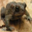

In [ ]:
test_im

In [ ]:
avg_vec[0].shape

(768,)

In [ ]:
test_vector = iv.get_vec(test_im)
test_vector=test_vector.squeeze()

In [ ]:
test_vector.shape

(768,)

<ipython-input-32-09d8fe90a372>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", avg_vec.shape[0])  # A colormap with unique colors

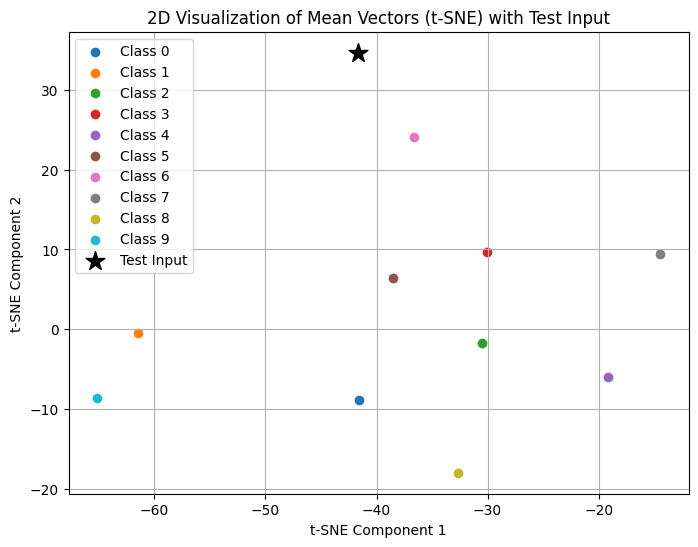

In [ ]:
# Combine avg_vec and test_vector
combined_vec = np.vstack([avg_vec, test_vector])  # Shape becomes (11, 512)

# Reduce the dimensionality to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
combined_vec_2d = tsne.fit_transform(combined_vec)

# Separate the transformed data
avg_vec_2d = combined_vec_2d[:-1]  # First 10 points are the classes
test_vec_2d = combined_vec_2d[-1]  # Last point is the test vector

# Visualize the 2D scatter plot
plt.figure(figsize=(8, 6))

# Assign unique colors for each class
colors = plt.cm.get_cmap("tab10", avg_vec.shape[0])  # A colormap with unique colors

for i in range(avg_vec_2d.shape[0]):
    plt.scatter(avg_vec_2d[i, 0], avg_vec_2d[i, 1],
                label=f"Class {i}", color=colors(i))

# Add the test vector to the plot with a unique marker and color
plt.scatter(test_vec_2d[0], test_vec_2d[1], label="Test Input", color="black", marker="*", s=200)

# Add labels, title, and legend
plt.title("2D Visualization of Mean Vectors (t-SNE) with Test Input")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.grid()

plt.show()

In [ ]:
distances = np.linalg.norm(avg_vec_2d - test_vec_2d, axis=1)

# Display distances
for i, dist in enumerate(distances):
    print(f"Distance from test_vec_2d to Class {i}: {dist:.4f}")

Distance from test_vec_2d to Class 0: 43.5223
Distance from test_vec_2d to Class 1: 40.3474
Distance from test_vec_2d to Class 2: 38.0372
Distance from test_vec_2d to Class 3: 27.5113
Distance from test_vec_2d to Class 4: 46.4105
Distance from test_vec_2d to Class 5: 28.4357
Distance from test_vec_2d to Class 6: 11.7325
Distance from test_vec_2d to Class 7: 37.0444
Distance from test_vec_2d to Class 8: 53.3621
Distance from test_vec_2d to Class 9: 49.2070

In [ ]:
np.argmin(distances)

6

### Prediction

In [25]:
def predict_class_orig(avg_vec, test_im):
    test_vector = iv.get_vec(test_im)
    test_vector =test_vector.squeeze()
    # combined_vec = np.vstack([avg_vec, test_vector])  # Shape becomes (11, 512)

    # # Reduce the dimensionality to 2D using t-SNE
    # tsne = TSNE(n_components=2, random_state=42, perplexity=5)
    # combined_vec_2d = tsne.fit_transform(combined_vec)

    # # Separate the transformed data
    # avg_vec_2d = combined_vec_2d[:-1]  # First 10 points are the classes
    # test_vec_2d = combined_vec_2d[-1]

    distances = np.linalg.norm(avg_vec - test_vector, axis=1)
    return np.argmin(distances)

In [55]:
def predicted_targets_orig(test_set, avg_vec):
    preds = []
    for nda in test_set:
        test_im = Image.fromarray(nda)
        class_pred = predict_class_orig(avg_vec, test_im)
        preds.append(class_pred)
    return np.array(preds)

#### Testing One iteration for D1 and D2 Manually

checking train accuracy on Data set 1

In [ ]:
y_hat = predicted_targets_orig(data, avg_vec)

In [ ]:
y_hat

array([6, 9, 8, ..., 9, 9, 7])

In [ ]:
y_t

array([5, 3, 7, ..., 5, 4, 6])

In [ ]:
targets.shape

(2500,)

In [ ]:
y_hat.shape

(2500,)

In [ ]:
y_t.shape

(2500,)

In [ ]:
correct = 0
for i in range(2500):
    if targets[i] == y_hat[i]:
        correct+=1

Train accuracy for D1 

In [ ]:
correct/2500

0.9476

ViT eval1 Prediction and Accuracy

In [ ]:
t_eval1 = torch.load(r"/content/1_eval_data.tar.pth")
eval_data1, eval_targets1 = t_eval1['data'], t_eval1['targets']

<ipython-input-47-3e73d66c01c1>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  t_eval1 = torch.load(r"/content/1_eval_data.tar.pth")

In [ ]:
yhat_eval1 = predicted_targets_orig(eval_data1, avg_vec)

#### Accuaracy on evaluation dataset 1

In [ ]:
correct = 0
for i in range(2500):
    if eval_targets1[i] == yhat_eval1[i]:
        correct+=1

print(correct/2500)

0.9416

#### Loading dataset2

In [ ]:
t2 = torch.load(r'/content/2_train_data.tar.pth')
print(t2.keys()) # it will print data and targets
data2 = t2['data'] # both numpy.ndarray

dict_keys(['data'])

<ipython-input-50-25f7ae48c904>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  t2 = torch.load(r'/content/2_train_data.tar.pth')

#### Predictiong Psuedo labels for train dataset2

In [ ]:
targets2 = predicted_targets_orig(data2, avg_vec)

In [ ]:
np.unique(targets2)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
vecs2 = []
for cls in unique_classes:
    cls_imgs2 = data2[targets2 == cls]
    cls_vecs2 = []
    for imgs in cls_imgs2:
        im = Image.fromarray(imgs)
        features = iv.get_vec(im)
        cls_vecs2.append(features)
    vecs2.append(cls_vecs)

In [ ]:
avg_vec2 = []
for i in vecs:
    arr = np.array(i)
    mean = np.mean(arr, axis = 0)
    avg_vec2.append(mean)
avg_vec2 = np.array(avg_vec)

#### Loading evaluation dataset for dataset2 and ultimatley gauging accuaracy of model 2 (f2)

In [ ]:
testt2 = torch.load(r'/content/2_eval_data.tar.pth')
print(testt2.keys()) # it will print data and targets
input2, y_t2 = testt2['data'], testt2['targets'] # both numpy.ndarray

dict_keys(['data', 'targets'])

<ipython-input-56-99d76e2c38a1>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  testt2 = torch.load(r'/content/2_eval_data.tar.pth')

In [ ]:
y_t2.shape

(2500,)

In [ ]:
targets2.shape

(2500,)

In [ ]:
train_yp = predicted_targets_orig(data2, avg_vec2)
y_hat2 = predicted_targets_orig(input2, avg_vec2)

In [ ]:
correct = 0
for i in range(2500):
    if targets2[i] == train_yp[i]:
        correct+=1

train accuracy was expected to be 1

In [ ]:
correct/2500

1.0

In [ ]:
corrett = 0
for i in range(2500):
    if y_t2[i] == y_hat2[i]:
        corrett+=1

accuracy on Evaluation dataset 2

In [ ]:
corrett/2500

0.9444

### The above cell demostrated 1 iteration for the training and evaluation loop the next part will show the implementation

In [28]:
trainpaths = [
    "/kaggle/input/train-data-part-1/1_train_data.tar.pth",
    "/kaggle/input/train-data-part-1/3_train_data.tar.pth",
    "/kaggle/input/train-data-part-1/4_train_data.tar.pth",
    "/kaggle/input/train-data-part-1/5_train_data.tar.pth",
    "/kaggle/input/train-data-part-1/6_train_data.tar.pth",
    "/kaggle/input/train-data-part-1/7_train_data.tar.pth",
    "/kaggle/input/train-data-part-1/8_train_data.tar.pth",
    "/kaggle/input/train-data-part-1/9_train_data.tar.pth",
    "/kaggle/input/train-data-part-1/10_train_data.tar.pth"
]

testpaths = [
    "/kaggle/input/evaldata-part-1/1_eval_data.tar.pth",
    "/kaggle/input/evaldata-part-1/3_eval_data.tar.pth",
    "/kaggle/input/evaldata-part-1/4_eval_data.tar.pth",
    "/kaggle/input/evaldata-part-1/5_eval_data.tar.pth",
    "/kaggle/input/evaldata-part-1/6_eval_data.tar.pth",
    "/kaggle/input/evaldata-part-1/7_eval_data.tar.pth",
    "/kaggle/input/evaldata-part-1/8_eval_data.tar.pth",
    "/kaggle/input/evaldata-part-1/9_eval_data.tar.pth",
    "/kaggle/input/evaldata-part-1/10_eval_data.tar.pth"
]

In [53]:
def create_prototype(data, targets):
    """
    Create class prototypes by averaging feature vectors for each class.
    :param data: Input data, assumed to be NumPy array of images.
    :param targets: Corresponding labels for the data.
    :return: Array of averaged feature vectors (prototypes) for each class.
    """
    vecs = []
    unique_classes = np.unique(targets)

    for cls in unique_classes:
        cls_imgs = data[targets == cls]  # Select all images of the current class
        cls_vecs = []
        for imgs in cls_imgs:
            im = Image.fromarray(imgs)  # Convert to PIL Image
            features = iv.get_vec(im)  # Extract feature vector
            cls_vecs.append(features.squeeze())  # Append feature vector

        vecs.append(cls_vecs)  # Append all vectors for the current class

    # Compute the mean vector for each class
    avg_vec = []
    for i in vecs:
        arr = np.array(i)  # Convert list of vectors to NumPy array
        mean = np.mean(arr, axis=0)  # Compute mean along the first axis
        avg_vec.append(mean)

    return np.array(avg_vec)  # Return prototypes as NumPy array

def calculate_accuracy(y1, y2):
    correct=0
    for i in range(2500):
        if y1[i]==y2[i]:
            correct+=1
    return correct/2500

#### fss saves the protypes created during the loop from D1 to D10

In [30]:
fss= [avg_vec]

#### The following loop implements Approach 1: Sequential Prototype Updating

In [ ]:
for i in range(len(trainpaths)):
    t=torch.load(trainpaths[i])
    data=t['data']
    pseudo_labels = predicted_targets_orig(data, avg_vec)
    avg_vec=create_prototype(data, pseudo_labels)
    teval=torch.load(testpaths[i])
    data_eval, targets_eval=teval['data'], teval['targets']
    yhat_eval=predicted_targets_orig(data_eval, avg_vec)
    acc=calculate_accuracy(targets_eval, yhat_eval)
    fss.append(avg_vec)
    print(f"Test accuracy for data {i+2}: {acc}")

<ipython-input-90-68381b42a5ed>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  t=torch.load(trainpaths[i])
<ipython-input-90-68381b42a5ed>:6: FutureWarning: You are using 

Test accuracy for data 2: 0.9204
Test accuracy for data 3: 0.91
Test accuracy for data 4: 0.9104
Test accuracy for data 5: 0.894
Test accuracy for data 6: 0.898
Test accuracy for data 7: 0.8968
Test accuracy for data 8: 0.8908
Test accuracy for data 9: 0.8928
Test accuracy for data 10: 0.8952

#### The next cells implement the Approach 2: Weighted Average Prototype Averaging

In [31]:
fs = [avg_vec]

In [ ]:
for i in range(len(trainpaths)):
    t=torch.load(trainpaths[i])
    data=t['data']
    avg_vec=fs[i]
    pseudo_labels = predicted_targets_orig(data, avg_vec)
    avg_vec_n=create_prototype(data, pseudo_labels)
    teval=torch.load(testpaths[i])
    data_eval, targets_eval=teval['data'], teval['targets']
    accc = []
    ff = []
    for j in range(10):
      step = 0.1
      avg_n = (avg_vec*(j*step)) + (avg_vec_n*((1-j*step)))
      yhat_eval=predicted_targets_orig(data_eval, avg_n)
      acc=calculate_accuracy(targets_eval, yhat_eval)
      print(f"Test accuracy for {j*10} percent of f{i+1} in f{i+2}: {acc}")
      accc.append(acc)
      ff.append(avg_n)
    score = max(accc)
    fs.append(ff[accc.index(score)])
    print(f"Test accuracy for data {i+2}: {score}")

<ipython-input-72-906f0a67748b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  t=torch.load(trainpaths[i])
<ipython-input-72-906f0a67748b>:7: FutureWarning: You are using 

Test accuracy for 0 percent of f1 in f2: 0.9204
Test accuracy for 10 percent of f1 in f2: 0.9216
Test accuracy for 20 percent of f1 in f2: 0.9256
Test accuracy for 30 percent of f1 in f2: 0.9276
Test accuracy for 40 percent of f1 in f2: 0.9296
Test accuracy for 50 percent of f1 in f2: 0.934
Test accuracy for 60 percent of f1 in f2: 0.9364
Test accuracy for 70 percent of f1 in f2: 0.9404
Test accuracy for 80 percent of f1 in f2: 0.9412
Test accuracy for 90 percent of f1 in f2: 0.9424
Test accuracy for data 2: 0.9424
Test accuracy for 0 percent of f2 in f3: 0.9248
Test accuracy for 10 percent of f2 in f3: 0.9268
Test accuracy for 20 percent of f2 in f3: 0.9292
Test accuracy for 30 percent of f2 in f3: 0.9316
Test accuracy for 40 percent of f2 in f3: 0.9324
Test accuracy for 50 percent of f2 in f3: 0.934
Test accuracy for 60 percent of f2 in f3: 0.9356
Test accuracy for 70 percent of f2 in f3: 0.9376
Test accuracy for 80 percent of f2 in f3: 0.9388
Test accuracy for 90 percent of f2 in f3

test loop for each data set with each model by both approach

In [39]:
testpath1 = [
    "/kaggle/input/evaldata-part-1/1_eval_data.tar.pth",
    "/kaggle/input/evaldata-part-1/2_eval_data.tar.pth",
    "/kaggle/input/evaldata-part-1/3_eval_data.tar.pth",
    "/kaggle/input/evaldata-part-1/4_eval_data.tar.pth",
    "/kaggle/input/evaldata-part-1/5_eval_data.tar.pth",
    "/kaggle/input/evaldata-part-1/6_eval_data.tar.pth",
    "/kaggle/input/evaldata-part-1/7_eval_data.tar.pth",
    "/kaggle/input/evaldata-part-1/8_eval_data.tar.pth",
    "/kaggle/input/evaldata-part-1/9_eval_data.tar.pth",
    "/kaggle/input/evaldata-part-1/10_eval_data.tar.pth"
]

In [ ]:
len(fss)

10

In [ ]:
len(testpath1)

10

In [ ]:
len(fs)

10

In [ ]:
for i in range(len(fss)):
  np.save(f'feature {i+1} a2.npy', fss[i])

In [ ]:
for i in range(len(testpath1)):
  for k in range(len(fss)):
    avg = fss[k]
    teval=torch.load(testpath1[i])
    data_eval, targets_eval=teval['data'], teval['targets']
    yeval = predicted_targets_orig(data_eval, avg)
    acc = calculate_accuracy(targets_eval, yeval)
    print(f"Test accuracy for data {i+1} and model {k+1}: {acc}")

<ipython-input-96-033e5e73ca7d>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teval=torch.load(testpath1[i])

Test accuracy for data 1 and model 1: 0.9416
Test accuracy for data 1 and model 2: 0.924
Test accuracy for data 1 and model 3: 0.906
Test accuracy for data 1 and model 4: 0.9
Test accuracy for data 1 and model 5: 0.8928
Test accuracy for data 1 and model 6: 0.8924
Test accuracy for data 1 and model 7: 0.8912
Test accuracy for data 1 and model 8: 0.8908
Test accuracy for data 1 and model 9: 0.8896
Test accuracy for data 1 and model 10: 0.8836
Test accuracy for data 2 and model 1: 0.9444
Test accuracy for data 2 and model 2: 0.9204
Test accuracy for data 2 and model 3: 0.902
Test accuracy for data 2 and model 4: 0.902
Test accuracy for data 2 and model 5: 0.8948
Test accuracy for data 2 and model 6: 0.8952
Test accuracy for data 2 and model 7: 0.8932
Test accuracy for data 2 and model 8: 0.8908
Test accuracy for data 2 and model 9: 0.8896
Test accuracy for data 2 and model 10: 0.8852
Test accuracy for data 3 and model 1: 0.9432
Test accuracy for data 3 and model 2: 0.9252
Test accuracy f

In [ ]:
for i in range(len(testpath1)):
  for k in range(len(fss)):
    avg = fs[k]
    teval=torch.load(testpath1[i])
    data_eval, targets_eval=teval['data'], teval['targets']
    yeval = predicted_targets_orig(data_eval, avg)
    acc = calculate_accuracy(targets_eval, yeval)
    print(f"Test accuracy for data {i+1} and model {k+1}: {acc}")

<ipython-input-97-54e3b47c58a7>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teval=torch.load(testpath1[i])

Test accuracy for data 1 and model 1: 0.9416
Test accuracy for data 1 and model 2: 0.9404
Test accuracy for data 1 and model 3: 0.938
Test accuracy for data 1 and model 4: 0.9376
Test accuracy for data 1 and model 5: 0.9364
Test accuracy for data 1 and model 6: 0.9336
Test accuracy for data 1 and model 7: 0.9316
Test accuracy for data 1 and model 8: 0.9292
Test accuracy for data 1 and model 9: 0.928
Test accuracy for data 1 and model 10: 0.9264
Test accuracy for data 2 and model 1: 0.9444
Test accuracy for data 2 and model 2: 0.9424
Test accuracy for data 2 and model 3: 0.9412
Test accuracy for data 2 and model 4: 0.9404
Test accuracy for data 2 and model 5: 0.9384
Test accuracy for data 2 and model 6: 0.936
Test accuracy for data 2 and model 7: 0.9328
Test accuracy for data 2 and model 8: 0.9308
Test accuracy for data 2 and model 9: 0.9276
Test accuracy for data 2 and model 10: 0.926
Test accuracy for data 3 and model 1: 0.9432
Test accuracy for data 3 and model 2: 0.9416
Test accurac

In [ ]:
/kaggle/input/lxp-efficient/pytorch/default/1/a2/feature 1 a1.npy

In [33]:
fs = []

In [35]:
for i in range(10):
    x = np.load(f'/kaggle/input/lxp-efficient/pytorch/default/1/a2/feature {i+1} a1.npy')
    fs.append(x)

In [36]:
len(fs)

10

In [37]:
fs[0]

array([[-0.68335456,  0.01412783,  0.05197821, ...,  0.25796676,
         0.20175768,  0.09471242],
       [-0.20824409, -0.68425703,  0.5943371 , ...,  0.3617585 ,
         0.09910443, -0.28716668],
       [-0.14560437, -0.52683073, -0.02486167, ...,  0.23931216,
         0.14165007, -0.09032436],
       ...,
       [-0.12918186, -0.5616755 , -0.09023402, ...,  0.1106096 ,
         0.07101265, -0.39145228],
       [-0.4585239 , -0.34915015,  0.12501319, ...,  0.34398907,
         0.15898933,  0.08365443],
       [-0.6697486 , -0.5951926 ,  0.84078884, ...,  0.36414367,
        -0.50713444,  0.2584515 ]], dtype=float32)

In [43]:
for i in range(7,len(testpath1)):
  for k in range(10):
    if i == 7 and k <=7: 
        continue
    avg = fs[k]
    teval=torch.load(testpath1[i])
    data_eval, targets_eval=teval['data'], teval['targets']
    yeval = predicted_targets_orig(data_eval, avg)
    acc = calculate_accuracy(targets_eval, yeval)
    print(f"Test accuracy for data {i+1} and model {k+1}: {acc}")

/tmp/ipykernel_30/3284037318.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teval=torch.load(testpath1[i])


Test accuracy for data 8 and model 9: 0.9312
Test accuracy for data 8 and model 10: 0.9292
Test accuracy for data 9 and model 1: 0.9452
Test accuracy for data 9 and model 2: 0.9444
Test accuracy for data 9 and model 3: 0.9428
Test accuracy for data 9 and model 4: 0.9416
Test accuracy for data 9 and model 5: 0.9388
Test accuracy for data 9 and model 6: 0.9376
Test accuracy for data 9 and model 7: 0.936
Test accuracy for data 9 and model 8: 0.934
Test accuracy for data 9 and model 9: 0.9328
Test accuracy for data 9 and model 10: 0.93
Test accuracy for data 10 and model 1: 0.954
Test accuracy for data 10 and model 2: 0.9532
Test accuracy for data 10 and model 3: 0.9504
Test accuracy for data 10 and model 4: 0.9484
Test accuracy for data 10 and model 5: 0.9464
Test accuracy for data 10 and model 6: 0.9444
Test accuracy for data 10 and model 7: 0.942
Test accuracy for data 10 and model 8: 0.9404
Test accuracy for data 10 and model 9: 0.9384
Test accuracy for data 10 and model 10: 0.9368
